<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/notebooks/Testing_GradientMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/dual-ascent.pdf

https://web.stanford.edu/class/ee364b/lectures/primal_dual_subgrad_slides.pdf

https://www.cvxpy.org/examples/basic/quadratic_program.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [27]:
def gmaker(grads, epochs = 100, method="simple", start="normal"):
    lr = 0.01
    n, d = grads.shape
    w = np.random.randn(d) if start=="normal" else np.zeros(d)
    max_count = 0
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w >= 0)) * ge
        # w = w_new/np.linalg.norm(w_new)
        w = w_new if method=="simple" else w_new/np.linalg.norm(w_new)
        pos_count = np.sum(grads@w>=0)
        max_count = pos_count if pos_count >= max_count else max_count
        # if pos_count >= max_count:
        #     max_count = pos_count
    print(f"For {epochs} epochs: {pos_count} out of {n}, and maximum of {max_count}")
    return w, (pos_count, max_count)

### Testcases

Now let's write some test cases to make sure everything is working correctly


In [3]:
shape = (2000, 7840)
grads = 1e-10*(1000*(np.random.randn(*shape)+1))*np.random.randn(*shape)

For 1 epochs: 2000 out of 2000, and maximum of 2000
For 10 epochs: 2000 out of 2000, and maximum of 2000
For 100 epochs: 2000 out of 2000, and maximum of 2000
For 1000 epochs: 2000 out of 2000, and maximum of 2000


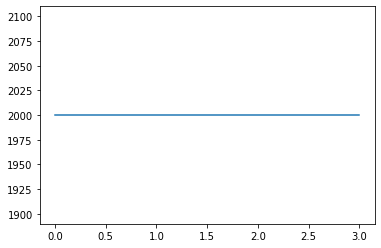

In [28]:
epochs_power = 4
counts = []
for i in [10**j for j in range(epochs_power)]:
    g, (pos_count, _) = gmaker(grads, epochs=i, start="zero")
    counts.append(pos_count)
plt.plot(list(range(epochs_power)), counts)